The objective is to make graphs that show player, line, or pair performance by varying levels of QoC and QoT. In the past, I've done it with hexbin charts, but here, I'll change things up a little, to show sample size.

In [1]:
player = 'Matt Niskanen'
team = 'WSH'
startseason = 2015
endseason = 2016
yaxis = 'F QoC Bin'
xaxis = 'F QoT Bin'

In [2]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import seaborn

In [3]:
dfs = []
for season in range(startseason, endseason + 1):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)

In [4]:
grouped = dfs[['Season', 'Player', 'Team', 'TOION(60s)', 'TOIOFF(60s)']].groupby(['Season', 'Player', 'Team']).sum()
grouped['TOI60'] = 60 * grouped['TOION(60s)'] / (grouped['TOION(60s)'] + grouped['TOIOFF(60s)'])
grouped.reset_index(inplace=True)
toi60 = {}
for i in range(len(grouped)):
    s = grouped['Season'].iloc[i]
    t = grouped['Team'].iloc[i]
    p = grouped['Player'].iloc[i]
    toi = grouped['TOI60'].iloc[i]
    if s not in toi60:
        toi60[s] = {}
    if t not in toi60[s]:
        toi60[s][t] = {}
    toi60[s][t][p] = toi

In [5]:
fopp = []
fteam = []
dopp = []
dteam = []
cf = []
ca = []
for season in range(startseason, endseason + 1):
    for line in pm2.read_team_corsi(team, season):
        if player in pm2.get_home_players(line):
            opponent = line[1][-3:]
            temp = []
            for p in pm2.get_home_players(line, ['F']):
                if not p == player:
                    temp.append(toi60[season][team][p])
            if len(temp) == 0:
                temp.append(0)
            fteam.append(mean(temp))

            temp = []
            for p in pm2.get_home_players(line, ['D']):
                if not p == player:
                    temp.append(toi60[season][team][p])
            if len(temp) == 0:
                temp.append(0)
            dteam.append(mean(temp))

            temp = []
            for p in pm2.get_road_players(line, ['F']):
                if not p == player:
                    temp.append(toi60[season][opponent][p])
            if len(temp) == 0:
                temp.append(0)
            fopp.append(mean(temp))

            temp = []
            for p in pm2.get_road_players(line, ['D']):
                if not p == player:
                    temp.append(toi60[season][opponent][p])
            if len(temp) == 0:
                temp.append(0)
            dopp.append(mean(temp))

            if pm2.get_acting_team(line) == team:
                cf.append(1)
                ca.append(0)
            else:
                cf.append(0)
                ca.append(1)
    print('Done with', season)

Done with 2015
Done with 2016


In [6]:
oppteamcfdf = pd.DataFrame({'F QoC': fopp, 'D QoC': dopp, 'F QoT': fteam, 'D QoT': dteam, 'CF': cf, 'CA': ca})
oppteamcfdf['F QoC Bin'] = oppteamcfdf['F QoC'].apply(lambda x: floor(x) + 0.5)
oppteamcfdf['D QoC Bin'] = oppteamcfdf['D QoC'].apply(lambda x: floor(x) + 0.5)
oppteamcfdf['F QoT Bin'] = oppteamcfdf['F QoT'].apply(lambda x: floor(x) + 0.5)
oppteamcfdf['D QoT Bin'] = oppteamcfdf['D QoT'].apply(lambda x: floor(x) + 0.5)
cfbinned = oppteamcfdf[[xaxis, yaxis, 'CF', 'CA']].groupby([xaxis, yaxis]).sum()
cfbinned.reset_index(inplace=True)
cfbinned['CFN'] = cfbinned['CF'] + cfbinned['CA']
cfbinned['CF%'] = cfbinned['CF'] / cfbinned['CFN']
cfbinned = cfbinned.sort_values(by='CFN', ascending=False)
cfbinned.head()

,F QoT Bin,F QoC Bin,CF,CA,CFN,CF%
64,16.5,16.5,257,226,483,0.532091
74,17.5,16.5,224,241,465,0.481720
65,16.5,17.5,211,163,374,0.564171
75,17.5,17.5,168,145,313,0.536741
63,16.5,15.5,122,110,232,0.525862


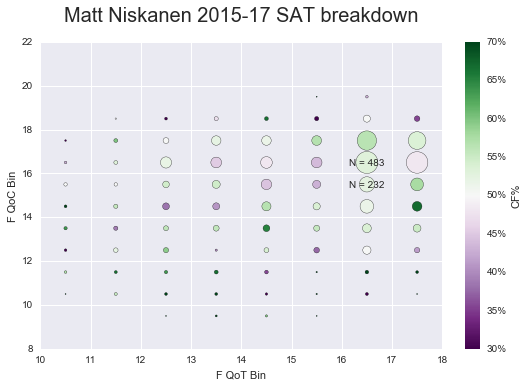

In [7]:
scatter(cfbinned[xaxis], cfbinned[yaxis], s=cfbinned['CFN'], c=cfbinned['CF%'], 
        cmap=plt.cm.PRGn, vmin = 0.3, vmax = 0.7)

annotate('N = {0:d}'.format(cfbinned['CFN'].iloc[0]), 
         xy=(cfbinned[xaxis].iloc[0], cfbinned[yaxis].iloc[0]),
         va = 'center', ha = 'center', size = 10)
cfbinnedhalved = cfbinned[cfbinned.CFN < cfbinned['CFN'].iloc[0] / 2]
annotate('N = {0:d}'.format(cfbinnedhalved['CFN'].iloc[0]), 
         xy=(cfbinnedhalved[xaxis].iloc[0], cfbinnedhalved[yaxis].iloc[0]),
         va = 'center', ha = 'center', size = 10)

cbar = colorbar(orientation='vertical', fraction=0.05)
cbar.set_label('CF%')
cbar.ax.set_yticklabels(['{0:d}%'.format(int(float(x.get_text()) * 100)) for x in cbar.ax.get_yticklabels()])
xlabel(xaxis)
ylabel(yaxis)
if isinstance(endseason, int):
    endseason = str(endseason + 1)[2:]
title('{0:s} {1:d}-{2:s} SAT breakdown'.format(player, startseason, endseason), y=1.05, size = 20)